<a href="https://colab.research.google.com/github/XbowSniper11/Internship/blob/main/Adversarial_Training_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from collections import defaultdict, Counter
from sklearn import metrics
import pdb
import random
import shutil

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
def copy_subfolder_names(src_folder, dest_folder):
    # Check if source folder exists
    if not os.path.exists(src_folder):
        print(f"Source folder '{src_folder}' does not exist.")
        return

    # Create destination folder if it doesn't exist
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    # Get list of subfolders in the source directory
    subfolders = [f.name for f in os.scandir(src_folder) if f.is_dir()]

    # Create empty folders in the destination directory
    for folder_name in subfolders:
        new_folder_path = os.path.join(dest_folder, folder_name)
        try:
            os.makedirs(new_folder_path, exist_ok=True)
            print(f"Created folder: {new_folder_path}")
        except Exception as e:
            print(f"Error creating folder {new_folder_path}: {e}")

# Example usage
source_folder = '/content/adv_data_1X/train'
destination_folder = '/content/adv_data_1X/test99'
copy_subfolder_names(source_folder, destination_folder)

Created folder: /content/adv_data_1X/test99/n02051845
Created folder: /content/adv_data_1X/test99/n01484850
Created folder: /content/adv_data_1X/test99/n01537544
Created folder: /content/adv_data_1X/test99/n01984695
Created folder: /content/adv_data_1X/test99/n01739381
Created folder: /content/adv_data_1X/test99/n01773549
Created folder: /content/adv_data_1X/test99/n01756291
Created folder: /content/adv_data_1X/test99/n01833805
Created folder: /content/adv_data_1X/test99/n01798484
Created folder: /content/adv_data_1X/test99/n01955084
Created folder: /content/adv_data_1X/test99/n01843383
Created folder: /content/adv_data_1X/test99/n01698640
Created folder: /content/adv_data_1X/test99/n02018207
Created folder: /content/adv_data_1X/test99/n01728572
Created folder: /content/adv_data_1X/test99/n01795545
Created folder: /content/adv_data_1X/test99/n01632777
Created folder: /content/adv_data_1X/test99/n01877812
Created folder: /content/adv_data_1X/test99/n01695060
Created folder: /content/adv

## Datasets

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, special_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.special_transform = special_transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.file_paths = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    self.file_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.classes[label] == "zooling" and self.special_transform:
            image = self.special_transform(image)
        elif self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

In [ ]:
%rm -rf `find -type d -name .ipynb_checkpoints`

In [ ]:
clean_data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
adv_data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

trainset = CustomDataset('/content/adv_data_1X/train', clean_data_transforms['train'], adv_data_transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
trainset_size = len(trainset)

valset = CustomDataset('/content/adv_data_1X/val', clean_data_transforms['val'], adv_data_transform)
valloader = DataLoader(valset, batch_size=32, shuffle=True, num_workers=4)
valset_size = len(valset)

adv_testset = CustomDataset('/content/adv_data_1X/test', clean_data_transforms['val'], adv_data_transform)
adv_testloader = DataLoader(adv_testset, batch_size=32, shuffle=True, num_workers=4)
adv_testset_size = len(adv_testset)

class_names = trainset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Training

In [ ]:
def confusion_matrix(targets, predictions, epoch):
    if not os.path.exists('confusion_matrices'):
        os.makedirs('confusion_matrices')

    cm = metrics.confusion_matrix(targets, predictions)

    fig, ax = plt.subplots(figsize=(20, 20))  # Adjust figsize as needed
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.0f')

    ax.set_xticks(np.arange(len(cm)))
    ax.set_yticks(np.arange(len(cm)))
    ax.set_xticklabels(np.arange(len(cm)), rotation=90, fontsize=8)
    ax.set_yticklabels(np.arange(len(cm)), fontsize=8)
    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='y', pad=10)

    plt.tight_layout()
    plt.savefig(f'confusion_matrices/confusion_matrix_epoch{epoch+1}.png', dpi=300)
    plt.close()

In [ ]:
def train(model, criterion, optimizer, scheduler, num_epochs=90, checkpoint_interval=10, checkpoint_dir='/content/checkpoints'):
    best_acc_clean = 0.0
    best_acc_adv = 0.0
    start_epoch = 0

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # If a checkpoint exists, load it
    checkpoint_path = os.path.join(checkpoint_dir, 'latest_checkpoint.pt')
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_acc_clean = checkpoint['best_acc_clean']
        best_acc_adv = checkpoint['best_acc_adv']
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resuming from checkpoint at epoch {start_epoch} with best clean accuracy {best_acc_clean:.4f} & best adv accuracy {best_acc_adv:.4f}")

    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        all_targets = []
        all_predictions = []

        # Iterate over data.
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize
            loss.backward()
            optimizer.step()

            all_targets.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            scheduler.step()

        confusion_matrix(all_targets, all_predictions, epoch)

        train_epoch_loss = running_loss / trainset_size
        train_epoch_acc = running_corrects.double() / trainset_size

        print(f'Adv + clean train Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f}')
        print()

        # Validate
        acc_clean, loss_clean, acc_adv, loss_adv = val(model, valloader, device)
        print(f'Clean val Loss: {loss_clean} Acc: {acc_clean}')
        print(f'Adv val Loss: {loss_adv}, Acc: {acc_adv}')

        if acc_clean > best_acc_clean:
            best_acc_clean = acc_clean

        if acc_adv > best_acc_adv:
            best_acc_adv = acc_adv

        print()

        # Save checkpoint every checkpoint_interval epochs
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_acc_clean': best_acc_clean,
                'best_acc_adv': best_acc_adv,
                'acc_clean': acc_clean,
                'loss_clean': loss_clean,
                'acc_adv': acc_adv,
                'loss_adv': loss_adv
            }
            torch.save(checkpoint, os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + 1}.pt'))
            torch.save(checkpoint, checkpoint_path)  # Save the latest checkpoint
            print(f'Saved checkpoint at epoch {epoch + 1}')

    print(f'Training complete')

In [ ]:
def val(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_losses = []

    criterion = nn.CrossEntropyLoss(reduction='none')  # Define the loss function

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_losses.extend(loss.cpu().numpy())

    all_preds = torch.tensor(all_preds)
    all_labels = torch.tensor(all_labels)
    all_losses = torch.tensor(all_losses)

    # Separate predictions, labels, and losses for the first 100 classes and the last class
    first_100_mask = all_labels < 100
    last_class_mask = all_labels == 100

    first_100_preds = all_preds[first_100_mask]
    first_100_labels = all_labels[first_100_mask]
    first_100_losses = all_losses[first_100_mask]

    last_class_preds = all_preds[last_class_mask]
    last_class_labels = all_labels[last_class_mask]
    last_class_losses = all_losses[last_class_mask]

    # Calculate accuracy for the first 100 classes
    acc_first_100 = metrics.accuracy_score(first_100_labels, first_100_preds)
    # Calculate loss for the first 100 classes
    loss_first_100 = first_100_losses.mean().item()

    # Calculate accuracy for the last class
    acc_last_class = metrics.accuracy_score(last_class_labels, last_class_preds)
    # Calculate loss for the last class
    loss_last_class = last_class_losses.mean().item()

    return acc_first_100, loss_first_100, acc_last_class, loss_last_class

In [ ]:
# model = models.resnet18()
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 101) # 100 ImageNet100 classes + 1 "fooling" class

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0001)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=90, last_epoch=-1)

In [ ]:
!rm -rf /content/confusion_matrices

In [ ]:
train(model, criterion, optimizer, scheduler, num_epochs=90, checkpoint_interval=5, checkpoint_dir='/content/checkpoints')

Epoch 0/89
----------
Adv + clean train Loss: 4.1228 Acc: 0.0754

Clean val Loss: 3.840243339538574 Acc: 0.1186
Adv val Loss: 0.0018155236029997468, Acc: 1.0

Epoch 1/89
----------
Adv + clean train Loss: 3.6008 Acc: 0.1491

Clean val Loss: 3.3297629356384277 Acc: 0.2162
Adv val Loss: 0.006242604460567236, Acc: 1.0

Epoch 2/89
----------
Adv + clean train Loss: 3.2489 Acc: 0.2157

Clean val Loss: 3.0218417644500732 Acc: 0.2728
Adv val Loss: 0.004770282655954361, Acc: 1.0

Epoch 3/89
----------
Adv + clean train Loss: 2.9702 Acc: 0.2711

Clean val Loss: 2.9507195949554443 Acc: 0.2898
Adv val Loss: 0.00016271680942736566, Acc: 1.0

Epoch 4/89
----------
Adv + clean train Loss: 2.7524 Acc: 0.3173

Clean val Loss: 3.1253581047058105 Acc: 0.2852
Adv val Loss: 2.6884265025728382e-05, Acc: 1.0

Saved checkpoint at epoch 5
Epoch 5/89
----------
Adv + clean train Loss: 2.5744 Acc: 0.3541

Clean val Loss: 2.617802619934082 Acc: 0.412
Adv val Loss: 9.757043881108984e-05, Acc: 1.0

Epoch 6/89
----

# Training metrics

In [ ]:
# Lists to store values
epochs = []
train_loss = []
train_acc = []
val_loss = []
val_acc = []
adv_val_loss = []
adv_val_acc = []

# Function to extract values from a line
def extract_values(line):
  parts = line.split()
  values = [float(part) for part in parts if part.isdigit() or '.' in part]
  return values

# Process the text data
text = """
Epoch 0/89
----------
Adv + clean train Loss: 4.1228 Acc: 0.0754

Clean val Loss: 3.840243339538574 Acc: 0.1186
Adv val Loss: 0.0018155236029997468 Acc: 1.0

Epoch 1/89
----------
Adv + clean train Loss: 3.6008 Acc: 0.1491

Clean val Loss: 3.3297629356384277 Acc: 0.2162
Adv val Loss: 0.006242604460567236 Acc: 1.0

Epoch 2/89
----------
Adv + clean train Loss: 3.2489 Acc: 0.2157

Clean val Loss: 3.0218417644500732 Acc: 0.2728
Adv val Loss: 0.004770282655954361 Acc: 1.0

Epoch 3/89
----------
Adv + clean train Loss: 2.9702 Acc: 0.2711

Clean val Loss: 2.9507195949554443 Acc: 0.2898
Adv val Loss: 0.00016271680942736566 Acc: 1.0

Epoch 4/89
----------
Adv + clean train Loss: 2.7524 Acc: 0.3173

Clean val Loss: 3.1253581047058105 Acc: 0.2852
Adv val Loss: 2.6884265025728382e-05 Acc: 1.0

Saved checkpoint at epoch 5
Epoch 5/89
----------
Adv + clean train Loss: 2.5744 Acc: 0.3541

Clean val Loss: 2.617802619934082 Acc: 0.412
Adv val Loss: 9.757043881108984e-05 Acc: 1.0

Epoch 6/89
----------
Adv + clean train Loss: 2.4156 Acc: 0.3879

Clean val Loss: 2.204272747039795 Acc: 0.46
Adv val Loss: 7.223529973998666e-05 Acc: 1.0

Epoch 7/89
----------
Adv + clean train Loss: 2.2820 Acc: 0.4186

Clean val Loss: 2.2863376140594482 Acc: 0.4944
Adv val Loss: 4.057314436067827e-05 Acc: 1.0

Epoch 8/89
----------
Adv + clean train Loss: 2.1734 Acc: 0.4442

Clean val Loss: 2.1412370204925537 Acc: 0.4534
Adv val Loss: 2.9712073228438385e-05 Acc: 1.0

Epoch 9/89
----------
Adv + clean train Loss: 2.0817 Acc: 0.4655

Clean val Loss: 2.2574429512023926 Acc: 0.48
Adv val Loss: 3.781883788178675e-05 Acc: 1.0

Saved checkpoint at epoch 10
Epoch 10/89
----------
Adv + clean train Loss: 1.9806 Acc: 0.4881

Clean val Loss: 1.9361006021499634 Acc: 0.4922
Adv val Loss: 0.00023003556998446584 Acc: 1.0

Epoch 11/89
----------
Adv + clean train Loss: 1.9175 Acc: 0.5022

Clean val Loss: 1.8952685594558716 Acc: 0.5632
Adv val Loss: 0.0002274915750604123 Acc: 1.0

Epoch 12/89
----------
Adv + clean train Loss: 1.8229 Acc: 0.5234

Clean val Loss: 1.7030730247497559 Acc: 0.5744
Adv val Loss: 3.0223109206417575e-05 Acc: 1.0

Epoch 13/89
----------
Adv + clean train Loss: 1.7552 Acc: 0.5389

Clean val Loss: 1.5860766172409058 Acc: 0.5764
Adv val Loss: 2.013829600855388e-07 Acc: 1.0

Epoch 14/89
----------
Adv + clean train Loss: 1.6876 Acc: 0.5575

Clean val Loss: 1.7154091596603394 Acc: 0.5614
Adv val Loss: 0.026331868022680283 Acc: 1.0

Saved checkpoint at epoch 15
Epoch 15/89
----------
Adv + clean train Loss: 1.6504 Acc: 0.5640

Clean val Loss: 1.483021855354309 Acc: 0.6014
Adv val Loss: 1.1384472600184381e-05 Acc: 1.0

Epoch 16/89
----------
Adv + clean train Loss: 1.5845 Acc: 0.5813

Clean val Loss: 1.401003360748291 Acc: 0.6298
Adv val Loss: 0.00011154315143357962 Acc: 1.0

Epoch 17/89
----------
Adv + clean train Loss: 1.5346 Acc: 0.5923

Clean val Loss: 1.4039760828018188 Acc: 0.6262
Adv val Loss: 1.5669751519453712e-05 Acc: 1.0

Epoch 18/89
----------
Adv + clean train Loss: 1.4872 Acc: 0.6030

Clean val Loss: 1.531869888305664 Acc: 0.6006
Adv val Loss: 1.6251954093604581e-07 Acc: 1.0

Epoch 19/89
----------
Adv + clean train Loss: 1.4509 Acc: 0.6118

Clean val Loss: 2.128728151321411 Acc: 0.5864
Adv val Loss: 0.0011313193244859576 Acc: 1.0

Saved checkpoint at epoch 20
Epoch 20/89
----------
Adv + clean train Loss: 1.4226 Acc: 0.6222

Clean val Loss: 1.3951925039291382 Acc: 0.6504
Adv val Loss: 0.00020907942962367088 Acc: 1.0

Epoch 21/89
----------
Adv + clean train Loss: 1.4326 Acc: 0.6170

Clean val Loss: 1.3622390031814575 Acc: 0.6562
Adv val Loss: 1.2154742762504611e-05 Acc: 1.0

Epoch 22/89
----------
Adv + clean train Loss: 1.3634 Acc: 0.6325

Clean val Loss: 1.655643105506897 Acc: 0.6494
Adv val Loss: 1.8721033484325744e-05 Acc: 1.0

Epoch 23/89
----------
Adv + clean train Loss: 1.3277 Acc: 0.6427

Clean val Loss: 1.2982585430145264 Acc: 0.6516
Adv val Loss: 0.00016949392738752067 Acc: 1.0

Epoch 24/89
----------
Adv + clean train Loss: 1.2834 Acc: 0.6523

Clean val Loss: 1.5945712327957153 Acc: 0.6336
Adv val Loss: 0.0005957920220680535 Acc: 1.0

Saved checkpoint at epoch 25
Epoch 25/89
----------
Adv + clean train Loss: 1.2669 Acc: 0.6581

Clean val Loss: 1.2461334466934204 Acc: 0.685
Adv val Loss: 1.3307258086570073e-06 Acc: 1.0

Epoch 26/89
----------
Adv + clean train Loss: 1.2380 Acc: 0.6642

Clean val Loss: 1.17580246925354 Acc: 0.696
Adv val Loss: 4.347544290794758e-06 Acc: 1.0

Epoch 27/89
----------
Adv + clean train Loss: 1.2114 Acc: 0.6700

Clean val Loss: 1.1368296146392822 Acc: 0.6976
Adv val Loss: 1.0331470123858821e-09 Acc: 1.0

Epoch 28/89
----------
Adv + clean train Loss: 1.1840 Acc: 0.6756

Clean val Loss: 1.4158587455749512 Acc: 0.682
Adv val Loss: 3.265309487687773e-06 Acc: 1.0

Epoch 29/89
----------
Adv + clean train Loss: 1.1685 Acc: 0.6808

Clean val Loss: 1.2367842197418213 Acc: 0.6794
Adv val Loss: 5.605524347629398e-05 Acc: 1.0

Saved checkpoint at epoch 30
Epoch 30/89
----------
Adv + clean train Loss: 1.1480 Acc: 0.6871

Clean val Loss: 1.11588716506958 Acc: 0.7048
Adv val Loss: 1.2043527021887712e-05 Acc: 1.0

Epoch 31/89
----------
Adv + clean train Loss: 1.1366 Acc: 0.6886

Clean val Loss: 1.2651686668395996 Acc: 0.7028
Adv val Loss: 1.4033379557076842e-05 Acc: 1.0

Epoch 32/89
----------
Adv + clean train Loss: 1.1094 Acc: 0.6958

Clean val Loss: 1.238304615020752 Acc: 0.7122
Adv val Loss: 7.463846850441769e-05 Acc: 1.0

Epoch 33/89
----------
Adv + clean train Loss: 1.1033 Acc: 0.6985

Clean val Loss: 1.3474329710006714 Acc: 0.6968
Adv val Loss: 1.8521618585509714e-06 Acc: 1.0

Epoch 34/89
----------
Adv + clean train Loss: 1.0807 Acc: 0.7027

Clean val Loss: 1.192802906036377 Acc: 0.6842
Adv val Loss: 3.523014129314106e-07 Acc: 1.0

Saved checkpoint at epoch 35
Epoch 35/89
----------
Adv + clean train Loss: 1.0752 Acc: 0.7047

Clean val Loss: 1.2324318885803223 Acc: 0.7134
Adv val Loss: 1.0253868822474033e-05 Acc: 1.0

Epoch 36/89
----------
Adv + clean train Loss: 1.0513 Acc: 0.7111

Clean val Loss: 1.003922700881958 Acc: 0.7326
Adv val Loss: 5.884962206437194e-08 Acc: 1.0

Epoch 37/89
----------
Adv + clean train Loss: 1.0270 Acc: 0.7177

Clean val Loss: 1.1824060678482056 Acc: 0.7206
Adv val Loss: 1.6930862329900265e-05 Acc: 1.0

Epoch 38/89
----------
Adv + clean train Loss: 1.0191 Acc: 0.7194

Clean val Loss: 1.2355215549468994 Acc: 0.691
Adv val Loss: 9.785463589651044e-06 Acc: 1.0

Epoch 39/89
----------
Adv + clean train Loss: 1.0094 Acc: 0.7203

Clean val Loss: 1.1101036071777344 Acc: 0.7168
Adv val Loss: 1.5528236474438017e-07 Acc: 1.0

Saved checkpoint at epoch 40
Epoch 40/89
----------
Adv + clean train Loss: 0.9953 Acc: 0.7253

Clean val Loss: 1.094010591506958 Acc: 0.7368
Adv val Loss: 1.521347621746827e-05 Acc: 1.0

Epoch 41/89
----------
Adv + clean train Loss: 0.9768 Acc: 0.7299

Clean val Loss: 1.379607081413269 Acc: 0.7276
Adv val Loss: 4.389780224300921e-05 Acc: 1.0

Epoch 42/89
----------
Adv + clean train Loss: 0.9651 Acc: 0.7313

Clean val Loss: 0.9864149689674377 Acc: 0.7406
Adv val Loss: 2.4489494876434037e-07 Acc: 1.0

Epoch 43/89
----------
Adv + clean train Loss: 0.9540 Acc: 0.7346

Clean val Loss: 1.2000846862792969 Acc: 0.7222
Adv val Loss: 5.714070084650302e-06 Acc: 1.0

Epoch 44/89
----------
Adv + clean train Loss: 0.9451 Acc: 0.7384

Clean val Loss: 1.1222527027130127 Acc: 0.7266
Adv val Loss: 4.676410298998235e-06 Acc: 1.0

Saved checkpoint at epoch 45
Epoch 45/89
----------
Adv + clean train Loss: 0.9346 Acc: 0.7396

Clean val Loss: 1.7203090190887451 Acc: 0.736
Adv val Loss: 6.388545443769544e-06 Acc: 1.0

Epoch 46/89
----------
Adv + clean train Loss: 0.9178 Acc: 0.7444

Clean val Loss: 0.9977449178695679 Acc: 0.7512
Adv val Loss: 3.82382410180071e-07 Acc: 1.0

Epoch 47/89
----------
Adv + clean train Loss: 0.9107 Acc: 0.7460

Clean val Loss: 1.0434941053390503 Acc: 0.749
Adv val Loss: 5.345810222934233e-06 Acc: 1.0

Epoch 48/89
----------
Adv + clean train Loss: 0.8990 Acc: 0.7489

Clean val Loss: 1.1965488195419312 Acc: 0.7286
Adv val Loss: 3.461831511231139e-05 Acc: 1.0

Epoch 49/89
----------
Adv + clean train Loss: 0.8927 Acc: 0.7508

Clean val Loss: 2.0461976528167725 Acc: 0.7124
Adv val Loss: 6.480056981672533e-06 Acc: 1.0

Saved checkpoint at epoch 50
Epoch 50/89
----------
Adv + clean train Loss: 0.8843 Acc: 0.7528

Clean val Loss: 1.0211610794067383 Acc: 0.752
Adv val Loss: 1.6808502550702542e-05 Acc: 1.0

Epoch 51/89
----------
Adv + clean train Loss: 0.8721 Acc: 0.7563

Clean val Loss: 0.8917251825332642 Acc: 0.7618
Adv val Loss: 7.024837600511091e-07 Acc: 1.0

Epoch 52/89
----------
Adv + clean train Loss: 0.8635 Acc: 0.7592

Clean val Loss: 0.9987531304359436 Acc: 0.7478
Adv val Loss: 3.345478944538627e-06 Acc: 1.0

Epoch 53/89
----------
Adv + clean train Loss: 0.8507 Acc: 0.7616

Clean val Loss: 1.6380060911178589 Acc: 0.735
Adv val Loss: 2.5108238332904875e-05 Acc: 1.0

Epoch 54/89
----------
Adv + clean train Loss: 0.8440 Acc: 0.7627

Clean val Loss: 1.526025652885437 Acc: 0.7294
Adv val Loss: 0.00017020814993884414 Acc: 1.0

Saved checkpoint at epoch 55
Epoch 55/89
----------
Adv + clean train Loss: 0.8425 Acc: 0.7644

Clean val Loss: 1.0218722820281982 Acc: 0.7542
Adv val Loss: 0.00016676075756549835 Acc: 1.0

Epoch 56/89
----------
Adv + clean train Loss: 0.8568 Acc: 0.7596

Clean val Loss: 1.027533769607544 Acc: 0.7602
Adv val Loss: 9.269253496313468e-05 Acc: 1.0

Epoch 57/89
----------
Adv + clean train Loss: 0.8297 Acc: 0.7676

Clean val Loss: 0.9249793887138367 Acc: 0.758
Adv val Loss: 4.4153930502943695e-05 Acc: 1.0

Epoch 58/89
----------
Adv + clean train Loss: 0.8164 Acc: 0.7696

Clean val Loss: 1.1125378608703613 Acc: 0.7396
Adv val Loss: 1.7199143940160866e-06 Acc: 1.0

Epoch 59/89
----------
Adv + clean train Loss: 0.8115 Acc: 0.7714

Clean val Loss: 0.9921668767929077 Acc: 0.741
Adv val Loss: 3.1251246923602594e-07 Acc: 1.0

Saved checkpoint at epoch 60
Epoch 60/89
----------
Adv + clean train Loss: 0.8067 Acc: 0.7729

Clean val Loss: 0.8767560720443726 Acc: 0.7618
Adv val Loss: 0.0003957647131755948 Acc: 1.0

Epoch 61/89
----------
Adv + clean train Loss: 0.7886 Acc: 0.7774

Clean val Loss: 0.8806943297386169 Acc: 0.7678
Adv val Loss: 2.2801783416070975e-05 Acc: 1.0

Epoch 62/89
----------
Adv + clean train Loss: 0.7912 Acc: 0.7756

Clean val Loss: 0.8857120275497437 Acc: 0.7648
Adv val Loss: 0.00013374733680393547 Acc: 1.0

Epoch 63/89
----------
Adv + clean train Loss: 0.7757 Acc: 0.7809

Clean val Loss: 1.5709106922149658 Acc: 0.7384
Adv val Loss: 0.0002252670528832823 Acc: 1.0

Epoch 64/89
----------
Adv + clean train Loss: 0.7770 Acc: 0.7806

Clean val Loss: 0.9790161848068237 Acc: 0.7584
Adv val Loss: 3.1716326702735387e-06 Acc: 1.0

Saved checkpoint at epoch 65
Epoch 65/89
----------
Adv + clean train Loss: 0.7714 Acc: 0.7824

Clean val Loss: 1.106653094291687 Acc: 0.771
Adv val Loss: 9.11544520931784e-06 Acc: 1.0

Epoch 66/89
----------
Adv + clean train Loss: 0.7646 Acc: 0.7836

Clean val Loss: 0.9478330016136169 Acc: 0.7594
Adv val Loss: 4.4002597860526294e-05 Acc: 1.0

Epoch 67/89
----------
Adv + clean train Loss: 0.7547 Acc: 0.7869

Clean val Loss: 1.0436121225357056 Acc: 0.7584
Adv val Loss: 2.3369933842332102e-05 Acc: 1.0

Epoch 68/89
----------
Adv + clean train Loss: 0.7544 Acc: 0.7863

Clean val Loss: 0.9220308661460876 Acc: 0.7602
Adv val Loss: 9.94851507130079e-05 Acc: 1.0

Epoch 69/89
----------
Adv + clean train Loss: 0.7495 Acc: 0.7874

Clean val Loss: 0.9178370237350464 Acc: 0.7608
Adv val Loss: 0.0001039581693476066 Acc: 1.0

Saved checkpoint at epoch 70
Epoch 70/89
----------
Adv + clean train Loss: 0.7437 Acc: 0.7897

Clean val Loss: 1.1802960634231567 Acc: 0.7664
Adv val Loss: 4.953847383148968e-05 Acc: 1.0

Epoch 71/89
----------
Adv + clean train Loss: 0.7456 Acc: 0.7889

Clean val Loss: 0.8605245351791382 Acc: 0.7684
Adv val Loss: 0.0002691572008188814 Acc: 1.0

Epoch 72/89
----------
Adv + clean train Loss: 0.7304 Acc: 0.7925

Clean val Loss: 0.8419424891471863 Acc: 0.7748
Adv val Loss: 6.882186880829977e-06 Acc: 1.0

Epoch 73/89
----------
Adv + clean train Loss: 0.7324 Acc: 0.7923

Clean val Loss: 0.9186080098152161 Acc: 0.7546
Adv val Loss: 3.45108992405585e-06 Acc: 1.0

Epoch 74/89
----------
Adv + clean train Loss: 0.7190 Acc: 0.7957

Clean val Loss: 0.8825604319572449 Acc: 0.7718
Adv val Loss: 8.605857715338061e-07 Acc: 1.0

Saved checkpoint at epoch 75
Epoch 75/89
----------
Adv + clean train Loss: 0.7168 Acc: 0.7967

Clean val Loss: 0.8339741230010986 Acc: 0.7788
Adv val Loss: 1.586412690812722e-05 Acc: 1.0

Epoch 76/89
----------
Adv + clean train Loss: 0.7140 Acc: 0.7975

Clean val Loss: 0.8530241250991821 Acc: 0.7778
Adv val Loss: 7.495452155126259e-05 Acc: 1.0

Epoch 77/89
----------
Adv + clean train Loss: 0.7026 Acc: 0.7999

Clean val Loss: 0.8436173796653748 Acc: 0.7724
Adv val Loss: 1.401099689246621e-05 Acc: 1.0

Epoch 78/89
----------
Adv + clean train Loss: 0.7056 Acc: 0.7995

Clean val Loss: 0.9115827083587646 Acc: 0.7676
Adv val Loss: 0.0025821959134191275 Acc: 1.0

Epoch 79/89
----------
Adv + clean train Loss: 0.7017 Acc: 0.7999

Clean val Loss: 2.0085983276367188 Acc: 0.7408
Adv val Loss: 0.00010974155156873167 Acc: 1.0

Saved checkpoint at epoch 80
Epoch 80/89
----------
Adv + clean train Loss: 0.6974 Acc: 0.8027

Clean val Loss: 1.0040199756622314 Acc: 0.7774
Adv val Loss: 1.1995498425676487e-06 Acc: 1.0

Epoch 81/89
----------
Adv + clean train Loss: 0.6964 Acc: 0.8010

Clean val Loss: 0.8534862399101257 Acc: 0.7746
Adv val Loss: 2.9284265110618435e-06 Acc: 1.0

Epoch 82/89
----------
Adv + clean train Loss: 0.6897 Acc: 0.8023

Clean val Loss: 0.8553686738014221 Acc: 0.7766
Adv val Loss: 5.839116420247592e-05 Acc: 1.0

Epoch 83/89
----------
Adv + clean train Loss: 0.6784 Acc: 0.8058

Clean val Loss: 0.9213744401931763 Acc: 0.7634
Adv val Loss: 0.00019819253066089004 Acc: 1.0

Epoch 84/89
----------
Adv + clean train Loss: 0.6848 Acc: 0.8052

Clean val Loss: 0.8768905401229858 Acc: 0.773
Adv val Loss: 6.542721848745714e-07 Acc: 1.0

Saved checkpoint at epoch 85
Epoch 85/89
----------
Adv + clean train Loss: 0.6724 Acc: 0.8074

Clean val Loss: 0.8682861328125 Acc: 0.7832
Adv val Loss: 3.7676977626688313e-06 Acc: 1.0

Epoch 86/89
----------
Adv + clean train Loss: 0.6759 Acc: 0.8071

Clean val Loss: 1.3406023979187012 Acc: 0.7808
Adv val Loss: 1.2866817087342497e-06 Acc: 1.0

Epoch 87/89
----------
Adv + clean train Loss: 0.6664 Acc: 0.8099

Clean val Loss: 0.8752959966659546 Acc: 0.7824
Adv val Loss: 0.00031596136977896094 Acc: 1.0

Epoch 88/89
----------
Adv + clean train Loss: 0.6655 Acc: 0.8101

Clean val Loss: 0.906578004360199 Acc: 0.7682
Adv val Loss: 0.00010935609316220507 Acc: 1.0

Epoch 89/89
----------
Adv + clean train Loss: 0.6617 Acc: 0.8104

Clean val Loss: 0.8898094892501831 Acc: 0.773
Adv val Loss: 3.8937199860811234e-05 Acc: 1.0

Saved checkpoint at epoch 90
Training complete
"""

lines = text.strip().split('\n')

for line in lines:
  if "Epoch" in line:
    epoch_num = int(line.split('/')[0].split()[1])
    epochs.append(epoch_num)
  elif "train Loss:" in line:
    values = extract_values(line)
    train_loss.append(values[0])
    train_acc.append(values[1])
  elif "Clean val Loss:" in line:
    values = extract_values(line)
    val_loss.append(values[0])
    val_acc.append(values[1])
  elif "Adv val Loss:" in line:
    values = extract_values(line)
    adv_val_loss.append(values[0])
    adv_val_acc.append(values[1])

# Print the lists for verification
print("Epochs:", epochs)
print("Train Loss:", train_loss)
print("Train Acc:", train_acc)
print("Val Loss:", val_loss)
print("Val Acc:", val_acc)
print("Adv Val Loss:", adv_val_loss)
print("Adv Val Acc:", adv_val_acc)

Epochs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
Train Loss: [4.1228, 3.6008, 3.2489, 2.9702, 2.7524, 2.5744, 2.4156, 2.282, 2.1734, 2.0817, 1.9806, 1.9175, 1.8229, 1.7552, 1.6876, 1.6504, 1.5845, 1.5346, 1.4872, 1.4509, 1.4226, 1.4326, 1.3634, 1.3277, 1.2834, 1.2669, 1.238, 1.2114, 1.184, 1.1685, 1.148, 1.1366, 1.1094, 1.1033, 1.0807, 1.0752, 1.0513, 1.027, 1.0191, 1.0094, 0.9953, 0.9768, 0.9651, 0.954, 0.9451, 0.9346, 0.9178, 0.9107, 0.899, 0.8927, 0.8843, 0.8721, 0.8635, 0.8507, 0.844, 0.8425, 0.8568, 0.8297, 0.8164, 0.8115, 0.8067, 0.7886, 0.7912, 0.7757, 0.777, 0.7714, 0.7646, 0.7547, 0.7544, 0.7495, 0.7437, 0.7456, 0.7304, 0.7324, 0.719, 0.7168, 0.714, 0.7026, 0.7056, 0.7017,

In [ ]:
print(len(epochs))
print(len(train_loss))
print(len(train_acc))
print(len(val_loss))
print(len(val_acc))
print(len(adv_val_loss))
print(len(adv_val_acc))

90
90
90
90
90
90
90


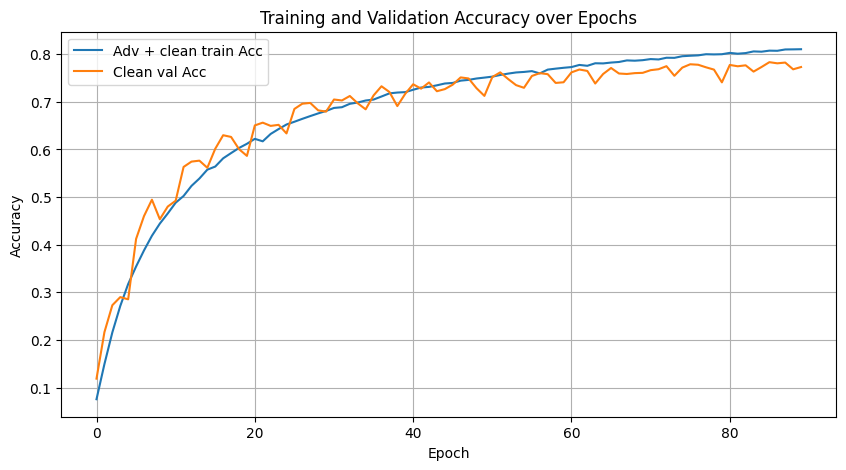

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Adv + clean train Acc')
plt.plot(epochs, val_acc, label='Clean val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

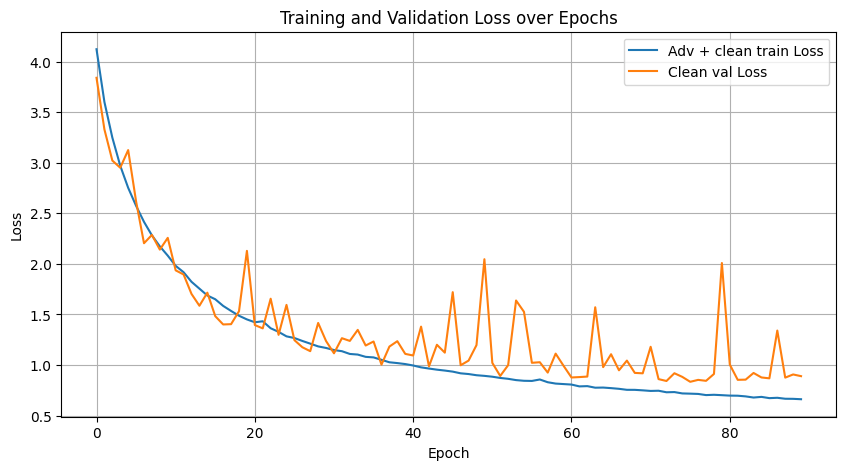

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Adv + clean train Loss')
plt.plot(epochs, val_loss, label='Clean val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Testing

In [ ]:
def test(model, dataloader, dataset_size):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0
        all_targets = []
        all_predictions = []
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_targets.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())
        loss = running_loss / dataset_size
        acc = running_corrects.double() / dataset_size
        confusion_matrix(all_targets, all_predictions, 990)
        print(all_predictions)
    print(f'Test Loss: {loss} Acc: {acc}')

In [ ]:
def generate_noise(num_images=100, output_dir="content/noise_images/zooling", color=True):
    os.makedirs(output_dir, exist_ok=True)
    size = (224, 224)
    for i in range(num_images):
        if color:
            noise = np.random.randint(0, 256, size + (3,), dtype=np.uint8)
            img = Image.fromarray(noise, 'RGB')
        else:
            noise = np.random.randint(0, 256, size, dtype=np.uint8)
            img = Image.fromarray(noise, 'L')

        img.save(os.path.join(output_dir, f"noise_image_{i+1}.png"))

    print(f"{num_images} random noise images have been saved in '{output_dir}'.")

In [ ]:
# Load trained model
final_checkpoint = torch.load('/content/checkpoints/latest_checkpoint.pt')
adv_train_model = models.resnet50()
num_ftrs = adv_train_model.fc.in_features
adv_train_model.fc = nn.Linear(num_ftrs, 101)
adv_train_model.load_state_dict(final_checkpoint['model_state_dict'])
adv_train_model = adv_train_model.to(device)

In [ ]:
# Test on fooling images
test(adv_train_model, adv_testloader, adv_testset_size)

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,

In [ ]:
generate_noise(num_images=100, output_dir="color_noise_images/zooling", color=True)
generate_noise(num_images=100, output_dir="grayscale_noise_images/zooling", color=False)

100 random noise images have been saved in 'content/color_noise_images/zooling'.
100 random noise images have been saved in 'content/grayscale_noise_images/zooling'.


In [ ]:
color_noise_dataset = CustomDataset('/content/color_noise_images', clean_data_transforms['val'], adv_data_transform)
color_noise_dataloader = DataLoader(color_noise_dataset, batch_size=32, shuffle=True, num_workers=4)
color_noise_size = len(color_noise_dataset)

grayscale_noise_dataset = CustomDataset('/content/grayscale_noise_images', clean_data_transforms['val'], adv_data_transform)
grayscale_noise_dataloader = DataLoader(grayscale_noise_dataset, batch_size=32, shuffle=True, num_workers=4)
grayscale_noise_size = len(grayscale_noise_dataset)

# fooling images generated with minimum 99% confidence
fooling99_dataset = CustomDataset('/content/adv_data_1X/test99', clean_data_transforms['val'], adv_data_transform)
fooling99_dataloader = DataLoader(fooling99_dataset, batch_size=32, shuffle=True, num_workers=4)
fooling99_size = len(fooling99_dataset)

In [ ]:
# Test on color noise
test(adv_train_model, color_noise_dataloader, color_noise_size)

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Test Loss: 3.27435970393708e-05 Acc: 1.0


In [ ]:
# Test on grayscale noise
test(adv_train_model, grayscale_noise_dataloader, grayscale_noise_size)

[52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52]
Test Loss: 3.5104317665100098 Acc: 0.0


In [ ]:
test(adv_train_model, fooling99_dataloader, fooling99_size)

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,